TieLent: A Casual Neck-Mounted Mouth Capturing Device for
Silent Speech Interaction

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('dataset/train')

label_types = os.listdir('dataset/train')
print (label_types)  

['bahlo', 'kharap', 'tumi']


# Preparing Training Data

In [2]:
rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('dataset/train' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('dataset/train' + '/' +item) + '/' + room))
    
# Build a dataframe        
train_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(train_df.head())
print(train_df.tail())

     tag                  video_name
0  bahlo   dataset/train/bahlo/1.mp4
1  bahlo  dataset/train/bahlo/10.mp4
2  bahlo  dataset/train/bahlo/11.mp4
3  bahlo  dataset/train/bahlo/12.mp4
4  bahlo  dataset/train/bahlo/13.mp4
      tag                 video_name
145  tumi  dataset/train/tumi/50.mp4
146  tumi   dataset/train/tumi/6.mp4
147  tumi   dataset/train/tumi/7.mp4
148  tumi   dataset/train/tumi/8.mp4
149  tumi   dataset/train/tumi/9.mp4


In [3]:
df = train_df.loc[:,['video_name','tag']]
df
df.to_csv('train.csv')

# Preparing Test Data

In [4]:
dataset_path = os.listdir('dataset/test')
print(dataset_path)

room_types = os.listdir('dataset/test')
print("Types of activities found: ", len(dataset_path))

rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('dataset/test' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('dataset/test' + '/' +item) + '/' + room))
    
# Build a dataframe        
test_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(test_df.head())
print(test_df.tail())

df = test_df.loc[:,['video_name','tag']]
df
df.to_csv('test.csv')

['bahlo', 'kharap', 'tumi']
Types of activities found:  3
     tag                 video_name
0  bahlo  dataset/test/bahlo/34.mp4
1  bahlo  dataset/test/bahlo/35.mp4
2  bahlo  dataset/test/bahlo/37.mp4
3  bahlo  dataset/test/bahlo/38.mp4
4  bahlo  dataset/test/bahlo/39.mp4
     tag               video_name
39  tumi  dataset/test/tumi/5.mp4
40  tumi  dataset/test/tumi/6.mp4
41  tumi  dataset/test/tumi/7.mp4
42  tumi  dataset/test/tumi/8.mp4
43  tumi  dataset/test/tumi/9.mp4


In [5]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
      try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
      except RuntimeError as e:
        print(e)

# Data preparation

In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")


train_df.sample(10)

Total videos for training: 150
Total videos for testing: 44


,Unnamed: 0,video_name,tag
16,16,dataset/train/bahlo/24.mp4,bahlo
11,11,dataset/train/bahlo/2.mp4,bahlo
106,106,dataset/train/tumi/15.mp4,tumi
17,17,dataset/train/bahlo/25.mp4,bahlo
135,135,dataset/train/tumi/41.mp4,tumi
43,43,dataset/train/bahlo/50.mp4,bahlo
138,138,dataset/train/tumi/44.mp4,tumi
103,103,dataset/train/tumi/12.mp4,tumi
75,75,dataset/train/kharap/33.mp4,kharap
126,126,dataset/train/tumi/33.mp4,tumi


# Feed the videos to a network:

In [8]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
IMG_SIZE = 224


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [9]:
# image generate

# # Opens the Video file
# cap= cv2.VideoCapture('E:/Research/Tilent/dataset/train/tumi/1.mp4')
# i=0
# while(cap.isOpened()):
#     ret, frame = cap.read()
#     if ret == False:
#         break
#     cv2.imwrite('kang'+str(i)+'.jpg',frame)
#     i+=1

# cap.release()
# cv2.destroyAllWindows()

In [10]:
im = plt.imread("images/kang0.jpg")
a = crop_center_square(im)

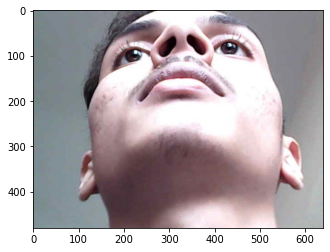

In [11]:
imgplot1 = plt.imshow(im)


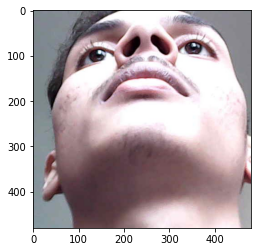

In [12]:
imgplot = plt.imshow(a)

# Feature Extraction

In [13]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

# Label Encoding
StringLookup layer encode the class labels as integers.

In [14]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
print(label_processor.get_vocabulary())

labels = train_df["tag"].values
labels = label_processor(labels[..., None]).numpy()
labels

['bahlo', 'kharap', 'tumi']


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

Finally, we can put all the pieces together to create our data processing utility.

In [15]:
#Define hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [16]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    
    ##take all classlabels from train_df column named 'tag' and store in labels
    labels = df["tag"].values
    
    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool") # 150,20
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") #150, 20, 2048

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")



print(f"train_labels in train set: {train_labels.shape}")

print(f"test_labels in train set: {test_labels.shape}")

# MAX_SEQ_LENGTH = 20, NUM_FEATURES = 2048. We have defined this above under hyper parameters

Frame features in train set: (150, 20, 2048)
Frame masks in train set: (150, 20)
train_labels in train set: (150, 1)
test_labels in train set: (44, 1)


# The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like GRU.

In [17]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

EPOCHS = 30
# Utility for running experiments.
def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/30
4/4 [==============================] - 10s 825ms/step - loss: 1.0980 - accuracy: 0.5619 - val_loss: 1.1035 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.10350, saving model to ./tmp\video_classifier
Epoch 2/30
4/4 [==============================] - 0s 33ms/step - loss: 1.0960 - accuracy: 0.3810 - val_loss: 1.1081 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 1.10350
Epoch 3/30
4/4 [==============================] - 0s 34ms/step - loss: 1.0940 - accuracy: 0.4762 - val_loss: 1.1128 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 1.10350
Epoch 4/30
4/4 [==============================] - 0s 33ms/step - loss: 1.0920 - accuracy: 0.4762 - val_loss: 1.1174 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 1.10350
Epoch 5/30
4/4 [==============================] - 0s 32ms/step - loss: 1.0901 - accuracy: 0.4762 - val_loss: 1.1221 - val_accuracy: 0.0000e+00

Epoch 00005: val_loss did not impr

# Inference

In [26]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")

test_frames = sequence_prediction(test_video)


Test video path: dataset/test/kharap/6.mp4
  kharap: 33.42%
  bahlo: 33.41%
  tumi: 33.17%


In [25]:
from IPython.display import HTML

HTML("""
    <video alt="test" controls>
        <source src="dataset/test/bahlo/37.mp4" type="video/mp4">
    </video>
""")